In [1]:
import pandas as pd
import numpy as np
from supabase import create_client
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, r2_score
import joblib
from dotenv import load_dotenv
import os


In [2]:
load_dotenv()

SUPABASE_URL = os.getenv("SUPABASE_URL")
SUPABASE_KEY = os.getenv("SUPABASE_KEY")

url = SUPABASE_URL
key = SUPABASE_KEY

supabase = create_client(url, key)


In [3]:
response = supabase.table("cost_estimations").select("*").execute()
data = response.data

df = pd.DataFrame(data)
df.head()


,id,filename,file_path,result,estimated_cost,created_at
0,f820ed37-a852-4ab0-a7d8-d79f9f355e85,Revolutionizing Surveillance with Deep Learnin...,Coal-research-files/Revolutionizing Surveillan...,{'raw_text': 'Revolutionizing Surveillance wit...,7250000,2025-11-13T18:21:21.292502+00:00
1,31401b0b-bfcd-4334-884e-3e116d48e7d4,Revolutionizing Surveillance with Deep Learnin...,Coal-research-files/Revolutionizing Surveillan...,{'raw_text': 'Revolutionizing Surveillance wit...,5100000,2025-11-14T02:26:33.985206+00:00
2,6de90c53-fb34-4331-9bac-96adb6fc00bb,Revolutionizing Surveillance with Deep Learnin...,Coal-research-files/Revolutionizing Surveillan...,{'raw_text': 'Revolutionizing Surveillance wit...,3475000,2025-11-14T09:02:53.385453+00:00
3,bc832f6d-3f3a-4eb3-8d2e-d28402ce0b8c,Revolutionizing Surveillance with Deep Learnin...,Coal-research-files/Revolutionizing Surveillan...,{'raw_text': 'Revolutionizing Surveillance wit...,0,2025-11-14T19:07:34.21829+00:00
4,0abb2be9-e11a-456f-a8bf-18fac9582f2d,Revolutionizing Surveillance with Deep Learnin...,Coal-research-files/Revolutionizing Surveillan...,{'raw_text': 'Revolutionizing Surveillance wit...,8720000,2025-11-14T19:15:36.378862+00:00


In [4]:
df["abstract"] = df["result"].apply(lambda r: r.get("raw_text", "") if r else "")
df["llm_cost"] = df["result"].apply(lambda r: r.get("estimated_cost", 0) if r else 0)

# If actual_cost exists, we use that; else we fall back to llm_cost as proxy
df["target"] = df["estimated_cost"].fillna(df["llm_cost"])

df = df[df["abstract"] != ""]
df = df[df["target"].notnull()]

X = df["abstract"]
y = df["target"].astype(float)


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=20000, ngram_range=(1,2))),
    ("regressor", Ridge(alpha=1.0))
])

model.fit(X_train, y_train)
pred = model.predict(X_test)


In [6]:
print("MAE:", mean_absolute_error(y_test, pred))
print("R2 Score:", r2_score(y_test, pred))


MAE: 4465578.947368421
R2 Score: -0.20696976456242844


In [8]:
os.makedirs("pre-trained", exist_ok=True)
joblib.dump(model, "pre-trained/main_cost_model.joblib")
print("Model saved to pre-trained/main_cost_model.joblib")

Model saved to pre-trained/main_cost_model.joblib


In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

y_pred = pred

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("📊 MODEL PERFORMANCE METRICS")
print("----------------------------")
print(f"MAE  : {mae}")
print(f"MSE  : {mse}")
print(f"RMSE : {rmse}")
print(f"R²   : {r2}")


📊 MODEL PERFORMANCE METRICS
----------------------------
MAE  : 4465578.947368421
MSE  : 22126893905817.176
RMSE : 4703923.246165606
R²   : -0.20696976456242844


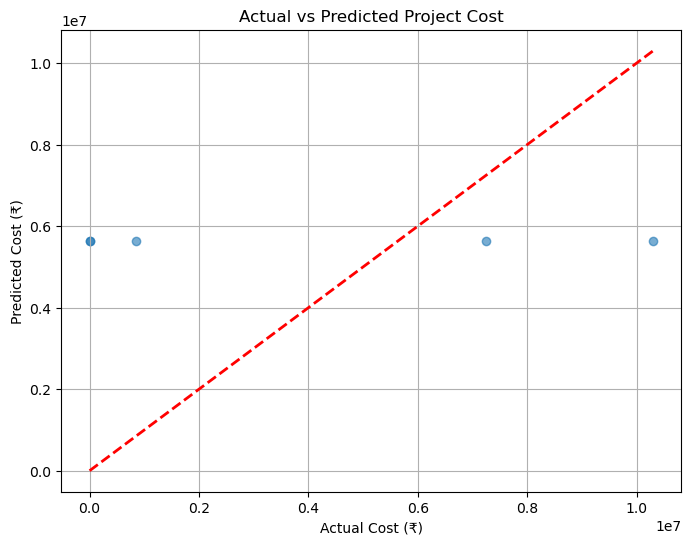

In [10]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         "r--", linewidth=2)

plt.title("Actual vs Predicted Project Cost")
plt.xlabel("Actual Cost (₹)")
plt.ylabel("Predicted Cost (₹)")
plt.grid(True)
plt.show()


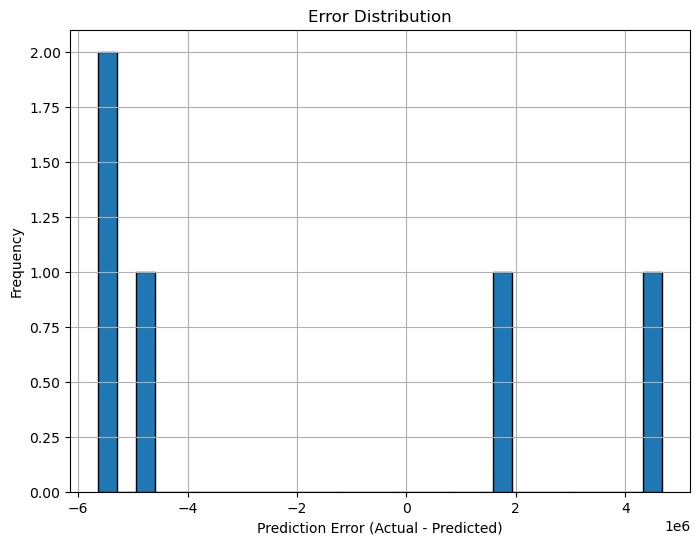

In [11]:
errors = y_test - y_pred

plt.figure(figsize=(8, 6))
plt.hist(errors, bins=30, edgecolor='black')
plt.title("Error Distribution")
plt.xlabel("Prediction Error (Actual - Predicted)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


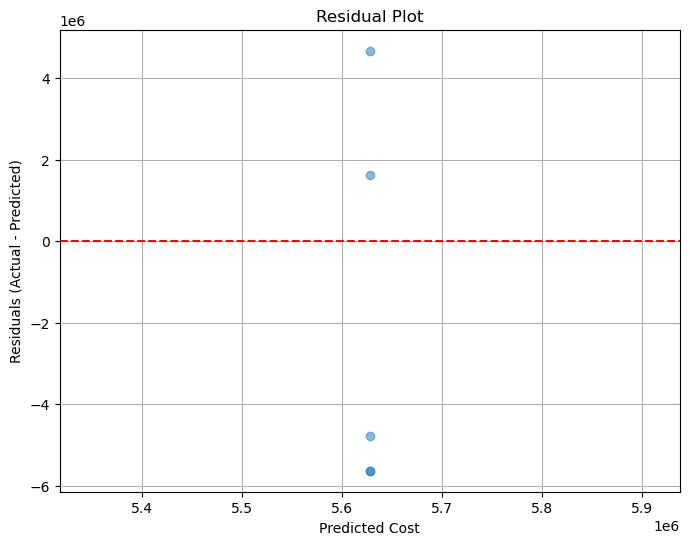

In [12]:
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, errors, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')

plt.title("Residual Plot")
plt.xlabel("Predicted Cost")
plt.ylabel("Residuals (Actual - Predicted)")
plt.grid(True)
plt.show()


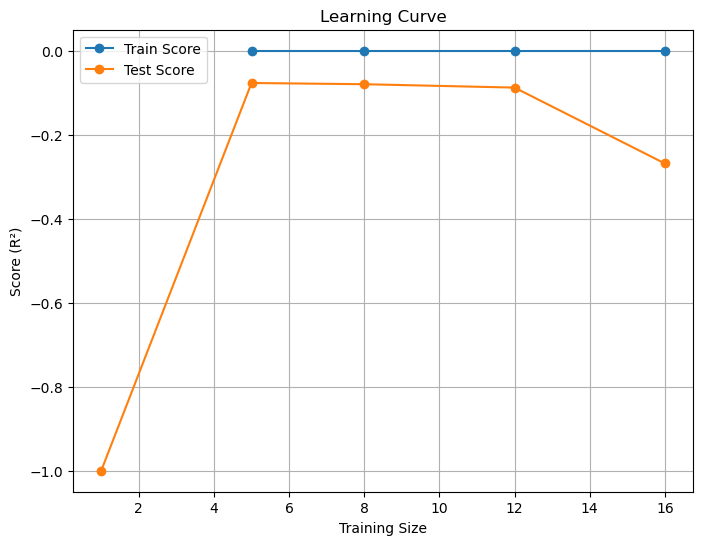

In [13]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    model,
    X,
    y,
    cv=3,
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5)
)

train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, 'o-', label="Train Score")
plt.plot(train_sizes, test_mean, 'o-', label="Test Score")

plt.title("Learning Curve")
plt.xlabel("Training Size")
plt.ylabel("Score (R²)")
plt.grid(True)
plt.legend()
plt.show()


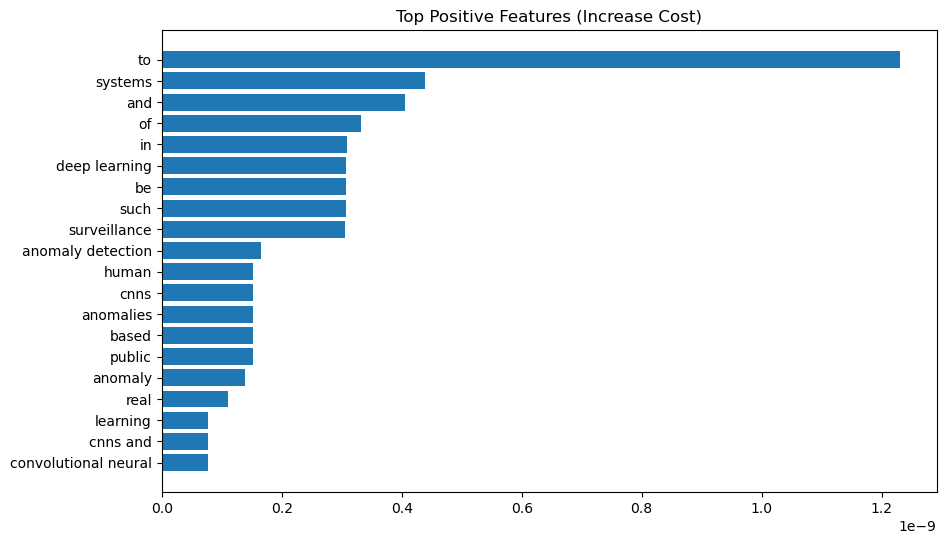

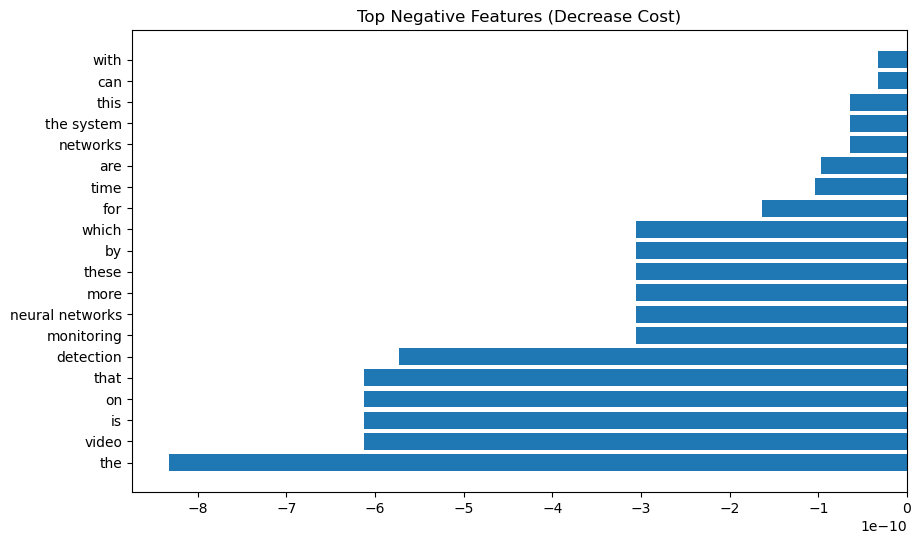

In [14]:
# Extract coefficients
vectorizer = model.named_steps["tfidf"]
regressor = model.named_steps["regressor"]

feature_names = np.array(vectorizer.get_feature_names_out())
coeffs = regressor.coef_

# Get top +ve and -ve features
top_pos = np.argsort(coeffs)[-20:]
top_neg = np.argsort(coeffs)[:20]

plt.figure(figsize=(10, 6))
plt.barh(feature_names[top_pos], coeffs[top_pos])
plt.title("Top Positive Features (Increase Cost)")
plt.show()

plt.figure(figsize=(10, 6))
plt.barh(feature_names[top_neg], coeffs[top_neg])
plt.title("Top Negative Features (Decrease Cost)")
plt.show()


In [15]:
supabase.table("model_accuracy_log").insert({
    "mae": float(mae),
    "r2": float(r2),
    "samples": len(df),
    "model_version": "v1"
}).execute()

print("Metrics saved to Supabase.")


Metrics saved to Supabase.
